## Probabilistic Programming Workflow

### Open Source Tools For Rapid Statistical (Bayesian) Model Development

### Overview
* Catching up with Probabilistic Programming
* Plan models -- causalgraphicalmodels
* Loading Data -- PanDaS
* Preparing Data -- PanDaS, Seaborn, Scikit-learn
* Rapid Model Development -- PyMC3
* Beyond the Basics

<a id='TOP'></a>
### Notebook Content:
1. [PP Overview](#Overview)
    1. PP as modeling framework
    2. Emphasis on generalizing predictive models
1. [Plan modeling](#ModelPlan)
2. [Loading Field Data](#DataLoad)
3. [Prepare Data for Modeling](#DataPrep)
4. [Bayesian Modelling](#PyMC3)
   1. [Model coding](#writemodel)
   2. [Prior evaluation & Model modification](#priors)
   3. [Model fitting & diagnostics](#fit)
   4. [Model Evaluation](#eval)
       1. [Deviance](#deviance)
       2. [Approximation by WAIC](#waic)
5. [Conclusion](Conclusion)

In [1]:
# STL
import os
import pickle
import sys

# numerical libraries
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# graphic facilities
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
print(f'Python: version {sys.version.split("|")[0]}')
print(f'PanDaS version {pd.__version__}')
print(f'Seaborn version {sb.__version__}')
print(f'PyMC3 version {pm.__version__}')

Python: version 3.7.1 
PanDaS version 0.24.1
Seaborn version 0.9.0
PyMC3 version 3.6


In [4]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

<a id=DataLoad></a>
## 2. "<u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<img src='./resources/nomad_seabass_v1_seawifs_map.png' width=600 title="NOMAD SeaWiFS validation match-up distribution"/>

<span style="font-size:16pt">$\Rightarrow$   <u>Predictors</u></span>
* sat_rrs  ~ satellite remote-sensing reflectance (sr-1)
* etopo2 ~ NGDC ETOPO2 water depth (meters)
* oisst    ~ optimal interpolation (OI) sea surface temperature (SST) (degrees C)
* senz     ~ satellite viewing (zenith) angle (degrees)
* solz     ~ solar zenith angle at time of satellite overpass (degrees)
---
<span style="font-size:16pt">$\Rightarrow$   <u>Predicted</u></span>
* chl ~ fluorometric chlorophyll a

<u>Other</u>
* id ~ NOMAD record identifier (unitless)

<span style="font-size:16pt">$\Rightarrow$   <u>File content</u></span>
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,

In [5]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            # collect column labels
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            # record columns to skip
            rowskips = i+1
            break

In [6]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [8]:
df.head(2)

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.51,39.52,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.29,25.11,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1


<a id=DataPrep></a>
## 3. <u>Data Preparation</u>
<br>

In [9]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))
df.drop(date_time_columns, axis=1, inplace=True)

In [10]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [11]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

In [12]:
df['chlor_a'] = df.apply(fill_chl, axis=1)

In [13]:
df['is_hplc'] = np.isfinite(df.chl_a)

In [14]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
chl        262 non-null float64
chl_a      33 non-null float64
chlor_a    292 non-null float64
dtypes: float64(3)
memory usage: 6.9 KB


In [15]:
df.loc[((np.isfinite(df.chl)) & (np.isfinite(df.chl_a))),['chl', 'chl_a', 'chlor_a']]

,chl,chl_a,chlor_a
49,0.28200,0.222000,0.222000
52,3.67900,1.985000,1.985000
200,0.21639,0.274645,0.274645


In [16]:
# Preprocess satellite data
df_sat = df.filter(regex='sat_rrs', axis=1).copy()
# Invalidate negative readings
df_sat[df_sat<=0] = np.NaN
# Log-transform rrs
df_log_sat = pd.DataFrame(np.log10(df_sat.values),
                          columns=[f'log_{col}' for col in df_sat.columns]
                         )

In [17]:
df.loc[df.etopo2<=0, 'etopo2'] = np.NaN

In [18]:
# Preprocess 
df_extr = df[['oisst']].merge(df_log_sat,
                                  right_index=True,
                                  left_index=True)
df_extr['coastal'] = df.etopo2<=30
df_extr['coastal'] = df_extr.coastal.astype('category').cat.codes.astype('int')
df_extr['log_chlor_a'] = np.log10(df.chlor_a.values)

In [19]:
df_extr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 9 columns):
oisst             292 non-null float64
log_sat_rrs412    276 non-null float64
log_sat_rrs443    285 non-null float64
log_sat_rrs490    291 non-null float64
log_sat_rrs510    292 non-null float64
log_sat_rrs555    292 non-null float64
log_sat_rrs670    281 non-null float64
coastal           292 non-null int64
log_chlor_a       292 non-null float64
dtypes: float64(8), int64(1)
memory usage: 20.6 KB


### Splitting data into training & testing sets

In [20]:
X = df_extr.loc[:, :'coastal']
y = df_extr.loc[:, ['log_chlor_a']] # extra brackets to retain DataFrame type

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=X.coastal)

In [22]:
X.coastal.value_counts(normalize=True)*100

0    67.808219
1    32.191781
Name: coastal, dtype: float64

In [23]:
X_train.coastal.value_counts(normalize=True)*100

0    67.579909
1    32.420091
Name: coastal, dtype: float64

In [24]:
X_test.coastal.value_counts(normalize=True)*100

0    68.493151
1    31.506849
Name: coastal, dtype: float64

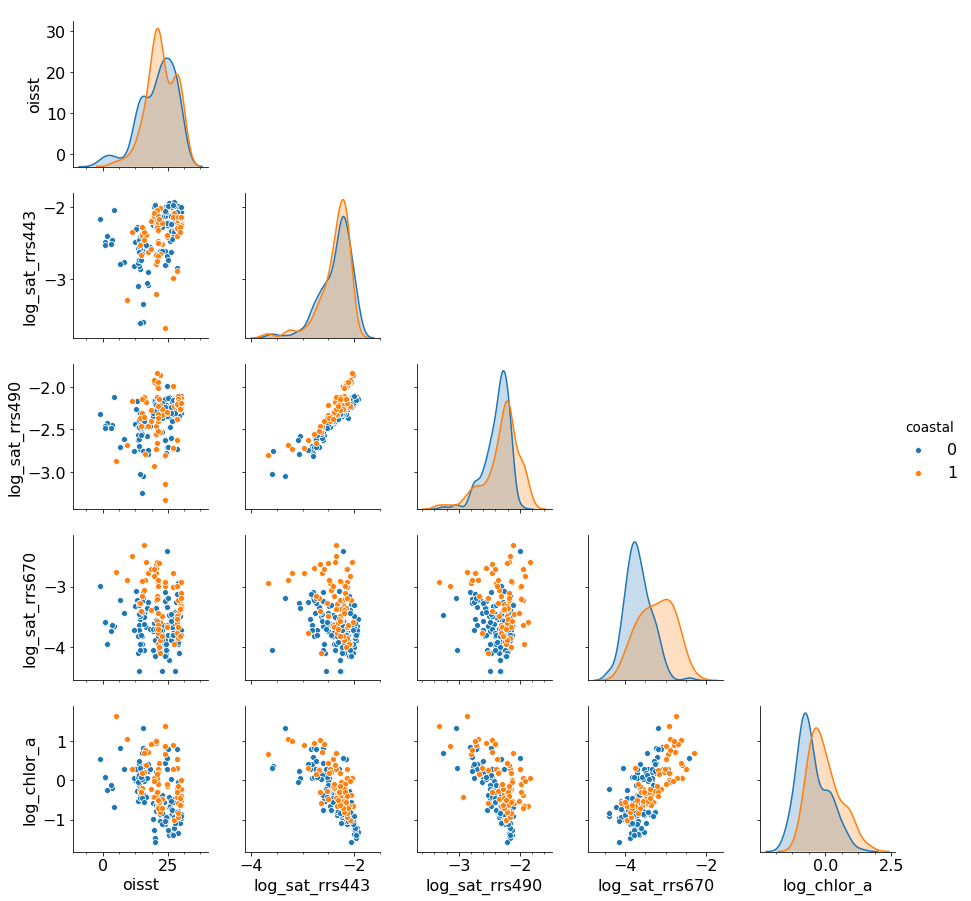

In [25]:
g = sb.pairplot(df_extr.iloc[X_train.index], hue='coastal', vars=['oisst', 'log_sat_rrs443',
                                              'log_sat_rrs490', 'log_sat_rrs670',
                                             'log_chlor_a'])
# mask upper triangle for readability
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
#f = pl.gcf()
g.savefig('./resources/pairgrid.png', dpi=300)

<img src='./resources/pairgrid.png?:2'/>

In [26]:
def make_heatmap(input_, filter_=None, figsize=(6, 5)):
    f, ax = pl.subplots(figsize=figsize)
    ax.set_facecolor('k')
    if filter_:
        input_ = input_.filter(regex=filter_, axis=1)
    corr_mat = input_.dropna().corr().iloc[1:, :-1]
    sb.heatmap(corr_mat, ax=ax, vmin=-1, vmax=1, 
               mask=np.triu(np.ones(corr_mat.shape),k=1), cmap='RdBu', fmt='.2f',
               annot=True)
    return f

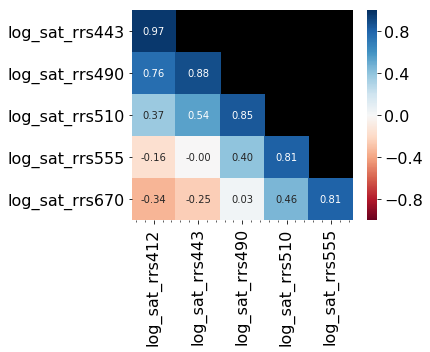

In [27]:
f = make_heatmap(X_train, filter_='rrs')
f.tight_layout()
f.savefig('./resources/heatmap_train.png')

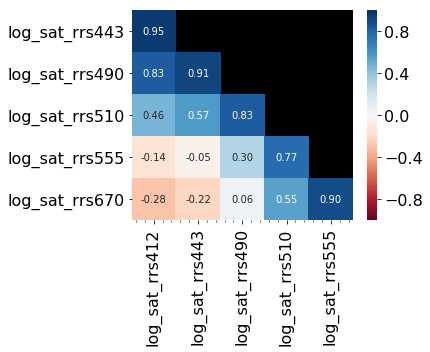

In [28]:
f = make_heatmap(X_test, filter_='rrs')
f.tight_layout()
f.savefig('./resources/heatmap_test.png')

<img src='./resources/heatmap_train.png?:2'/>

### Computing Principle Components

* parameterize PCA transformer using training set
* compute principle components for training set
* compute principle components for testing set with the same PCA transformer

In [29]:
# Isolate Rrs data in both training and test sets
X_train_rrs = X_train.filter(regex='rrs', axis=1).dropna()
X_test_rrs = X_test.filter(regex='rrs', axis=1).dropna()

# Instantiate PCA transformers
pca_transformer = PCA()

In [30]:
# parameterize transformer while rotating training data
X_train_pca = pca_transformer.fit_transform(X=X_train_rrs)

# apply same transformation to test set
X_test_pca = pca_transformer.transform(X=X_test_rrs)

In [31]:
X_train_pca = pd.DataFrame(X_train_pca,
                           columns=[f'PC{i}' for i in range(1, X_train_pca.shape[1]+1)],
                           index=X_train_rrs.index)
X_test_pca =  pd.DataFrame(X_test_pca, 
                           columns=[f'PC{i}' for i in range(1, X_test_pca.shape[1]+1)],
                           index=X_test_rrs.index)

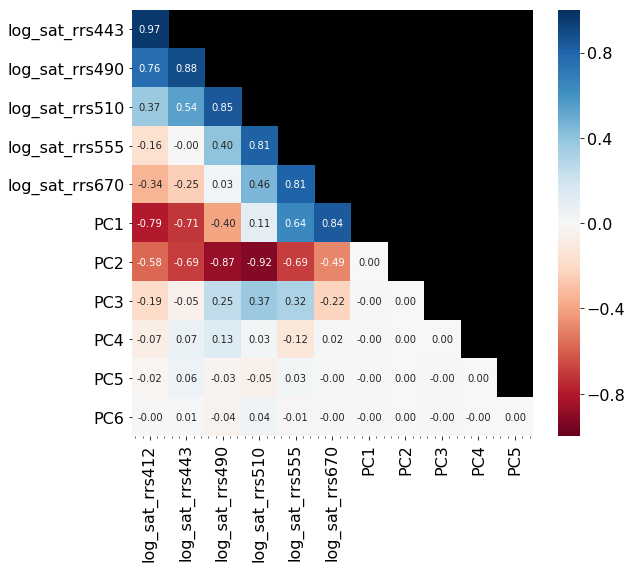

In [32]:
rrs_pc = X_train_rrs.merge(X_train_pca, how='outer',
                                left_index=True, right_index=True)
f = make_heatmap(rrs_pc, figsize=(9, 8))
f.tight_layout()
f.savefig('./resources/heatmap_x_train_pca.png', dpi=300)

<img src='./resources/heatmap_x_train_pca.png?:3'/>

In [33]:
X_train_pca = X_train_pca.merge(X_train[['oisst', 'coastal']], how='outer',
                               right_index=True, left_index=True)
X_test_pca = X_test_pca.merge(X_test[['oisst', 'coastal']], how='outer',
                             right_index=True, left_index=True)

In [34]:
X_train_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 4 to 291
Data columns (total 8 columns):
PC1        201 non-null float64
PC2        201 non-null float64
PC3        201 non-null float64
PC4        201 non-null float64
PC5        201 non-null float64
PC6        201 non-null float64
oisst      219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 15.4 KB


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 153 to 81
Data columns (total 8 columns):
oisst             219 non-null float64
log_sat_rrs412    205 non-null float64
log_sat_rrs443    212 non-null float64
log_sat_rrs490    218 non-null float64
log_sat_rrs510    219 non-null float64
log_sat_rrs555    219 non-null float64
log_sat_rrs670    211 non-null float64
coastal           219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


### Standardize data:

In [36]:
# Instantiate scalers

sc_X_rrs = StandardScaler()
sc_X_pca = StandardScaler()
sc_y = StandardScaler()

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 153 to 81
Data columns (total 8 columns):
oisst             219 non-null float64
log_sat_rrs412    205 non-null float64
log_sat_rrs443    212 non-null float64
log_sat_rrs490    218 non-null float64
log_sat_rrs510    219 non-null float64
log_sat_rrs555    219 non-null float64
log_sat_rrs670    211 non-null float64
coastal           219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [38]:
X_train_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 4 to 291
Data columns (total 8 columns):
PC1        201 non-null float64
PC2        201 non-null float64
PC3        201 non-null float64
PC4        201 non-null float64
PC5        201 non-null float64
PC6        201 non-null float64
oisst      219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 15.4 KB


In [39]:
# Parameterize scalers while standardizing training sets
X_train_s = sc_X_rrs.fit_transform(X_train.iloc[:, :-1])
X_train_pca_s = sc_X_pca.fit_transform(X_train_pca.iloc[:, :-1])
y_train_s = sc_y.fit_transform(y_train)

In [40]:
X_train_s = pd.DataFrame(X_train_s, index=X_train.index,
                         columns=[f'{col}_s' for col in X_train.iloc[:, :-1].columns])
X_train_s = X_train_s.merge(X_train[['coastal']], how='outer',
                            right_index=True, left_index=True)
X_train_pca_s = pd.DataFrame(X_train_pca_s, index=X_train_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_train_pca.iloc[:, :-1].columns])
X_train_pca_s = X_train_pca_s.merge(X_train_pca[['coastal']], how='outer',
                                   right_index=True, left_index=True)

In [41]:
y_train_s = pd.DataFrame(y_train_s, columns=y_train.columns, index=y_train.index)

In [42]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 153 to 81
Data columns (total 8 columns):
oisst_s             219 non-null float64
log_sat_rrs412_s    205 non-null float64
log_sat_rrs443_s    212 non-null float64
log_sat_rrs490_s    218 non-null float64
log_sat_rrs510_s    219 non-null float64
log_sat_rrs555_s    219 non-null float64
log_sat_rrs670_s    211 non-null float64
coastal             219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [43]:
X_train_pca_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 4 to 291
Data columns (total 8 columns):
PC1_s      201 non-null float64
PC2_s      201 non-null float64
PC3_s      201 non-null float64
PC4_s      201 non-null float64
PC5_s      201 non-null float64
PC6_s      201 non-null float64
oisst_s    219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 224 to 183
Data columns (total 8 columns):
oisst             73 non-null float64
log_sat_rrs412    71 non-null float64
log_sat_rrs443    73 non-null float64
log_sat_rrs490    73 non-null float64
log_sat_rrs510    73 non-null float64
log_sat_rrs555    73 non-null float64
log_sat_rrs670    70 non-null float64
coastal           73 non-null int64
dtypes: float64(7), int64(1)
memory usage: 7.6 KB


In [45]:
X_test_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 286
Data columns (total 8 columns):
PC1        68 non-null float64
PC2        68 non-null float64
PC3        68 non-null float64
PC4        68 non-null float64
PC5        68 non-null float64
PC6        68 non-null float64
oisst      73 non-null float64
coastal    73 non-null int64
dtypes: float64(7), int64(1)
memory usage: 5.1 KB


In [46]:
# Standardize test sets with parameterized scalers
X_test_s = sc_X_rrs.transform(X_test.iloc[:, :-1])
X_test_pca_s = sc_X_pca.transform(X_test_pca.iloc[:, :-1])
y_test_s = sc_y.transform(y_test)

In [47]:
X_test_s = pd.DataFrame(X_test_s, index=X_test.index,
                         columns=[f'{col}_s' for col in X_test.iloc[:, :-1].columns])

X_test_s = X_test_s.merge(X_test[['coastal']], how='outer',
                            right_index=True, left_index=True)
X_test_pca_s = pd.DataFrame(X_test_pca_s, index=X_test_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_train_pca.iloc[:, :-1].columns])
X_test_pca_s = X_test_pca_s.merge(X_test_pca[['coastal']], how='outer',
                                   right_index=True, left_index=True)

In [49]:
y_test_s = pd.DataFrame(y_test_s, columns=y_test.columns, index=y_test.index)

Modify X_train and X_test to make an OC4 compatible dataset

In [71]:
X_train = X_train.copy()
X_test = X_test.copy()
blue_band_cols = ['log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510']
X_train['MaxBlue'] = X_train[blue_band_cols].max(axis=1)
X_test['MaxBlue'] = X_test[blue_band_cols].max(axis=1)
X_train['MaxBlueId'] = X_train[blue_band_cols].idxmax(axis=1).astype('category').cat.codes
X_test['MaxBlueId'] = X_test[blue_band_cols].idxmax(axis=1).astype('category').cat.codes
X_train['MaxBlue2Gr'] = X_train.MaxBlue - X_train.log_sat_rrs555
X_test['MaxBlue2Gr'] = X_test.MaxBlue - X_test.log_sat_rrs555

In [72]:
X_train.head(2)

,oisst,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,coastal,MaxBlue,MaxBlueId,MaxBlue2Gr
153,29.78,-2.366532,-2.324222,-2.25649,-2.319664,-2.422508,-3.292430,1,-2.25649,1,0.166018
117,20.39,-2.191789,-2.071092,-1.94424,-2.015023,-2.176526,-3.221849,1,-1.94424,1,0.232286


### Before modeling: stash data sets and various transformer objects

In [73]:
train_dict = dict(X_rrs=X_train, X_rrs_s=X_train_s,
                  X_pca=X_train_pca, X_pca_s=X_train_pca_s,
                  y=y_train, y_s=y_train_s)

In [74]:
test_dict = dict(X_rrs=X_test, X_rrs_s=X_test_s,
                 X_pca=X_test_pca, X_pca_s=X_test_pca_s, 
                 y=y_test, y_s=y_test_s)

In [75]:
transformers_dict = dict(X_rrs_scaler=sc_X_rrs, X_pca_scaler=sc_X_pca, y_scaler=sc_y,
                         pca_tranf=pca_transformer)

In [76]:
preprocess_dict = dict(training=train_dict, testing=test_dict,
                       transformers=transformers_dict)

In [77]:
with open('./preprocess_dicts.pkl', 'wb') as fb:
    pickle.dump(preprocess_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
print(f"{os.path.getsize('./preprocess_dicts.pkl')/1000}kB")

101.708kB


## 4. Models:

* Polynomial model a la $OC_4$
* Multivariate model with Rrs data
* Multivariate model with Rrs data and SST
* Multivariate model with PC data 
* Multivariate model with PC data and SST

In [60]:
X_train_pca_s.head()

,PC1,PC2,PC3,PC4,PC5,PC6,oisst,coastal
0,0.178337,0.347346,0.014426,0.005602,-0.020029,0.003312,19.54,0
1,-0.283880,0.061130,-0.030231,0.016749,0.015289,0.019246,19.57,0
2,-0.441037,-0.176296,-0.173152,0.054049,-0.007605,0.012586,24.67,0
3,0.840595,0.786076,-0.104212,0.055694,-0.008955,0.009622,17.21,0
8,-0.054809,0.118185,-0.161581,0.036608,-0.006798,-0.010470,26.60,0
